## Select features which have good correlation with the target they said ##

Every machine learning course teaches us to select features which have good correlation with the target feature. As a beginner I thought this will be an easy job, just calculate correlation coefficient and select features. However when working with different datasets, I stumbled upon a problem where no feature had any correlation with the target (at least the numbers said so).

Therefore I did some research and found out that this is a very deep topic. I made a notebook with some of my findings in case somebody will find it useful.

Table of contents:

[1. Important definitions](#section-1)

[2. Correlation vs. Causation](#section-2)

[3. P-value](#section-3)

[4. Multicollinearity](#section-4)

[5. Data categories](#section-5)

[6. Numerical vs numerical correlation](#section-6)

[7. Categorical vs categorical correlation](#section-7)

[8. Numerical vs categorical correlation](#section-8)

<a id="section-1"></a>
# Imporant definitions #


> - independent features - columns of data in the dataset which are used to make a prediction
> - target feature - a column of data in the dataset that is being predicted
> - correlation - a statistical measure that expresses the extent to which two variables are related
> - correlation coefficient - a numerical measure of some type of correlation
> - causation - the relation of cause to effect
> - p-value - a measure of the probability that an observed difference could have occurred just by random chance
> - multicollinearity - happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy

<a id="section-2"></a>
# Correlation vs. Causation #

![](https://letstalkaboutscience.files.wordpress.com/2013/07/sharks-icon.png)

The first thing we need to know is the difference between correlation and causation. Lets see the difference with the following example:

1. Ice cream consumption is correlated to high temperatures

2. High temperatures are correlated to high swimming activity

3. High swimming activity is correlated to number of shark attacks


We need to ask ourselves if there is a cause to effect relationship. All of the above seem to pass the cause/effect check, therefore we have causation.

What about this one:
4. Ice cream consumption is correlated to number of shark attacks

It seems a bit odd but there actually is a correlation. However our common sense tells us there is no cause and effect, therefore we do not have causation.


The conclusion is that correlation does not automatically result into causation. What we are actually looking for in machine learning is causation!

<a id="section-3"></a>
# P-value #

When we are talking about correlation coefficients, we also need to take a look at p-value. The p-value tells us how much we can/can't trust the coefficients.
It is actually a probability that the result (coefficient) occurred by random chance - it ranges between 0 and 1 (0 and 100%).

Therefore we are aiming for the lowest possible p-value where the acceptable value is <0.05 (<5% probability that the result occured by random chance).

<a id="section-4"></a>
# Multicollinearity #

Multicollinearity occures when we have multiple features which tells us the same info. For example two boolean features - is_male and is_female:

| id | is_male | is_female |
|----|---------|-----------|
| 1  | TRUE    | FALSE     |
| 2  | FALSE   | TRUE      |
| 3  | FALSE   | TRUE      |


It seems a bit stupid to have two features for gender but that can occure quite often when creating dummy columns (one-hot encoding).
Both of the features are clearly correlated and they will result in less reliable model. This is really important for regression models, on the other hand tree based models are immune to multicollinearity.

<a id="section-5"></a>
# Data categories #

Data categorization:
- Numerical data
    * Discrete data - limited to the whole numbers only; number of employees, number of fixed assets etc.
    * Continuous data - it can take any decimal value between two numbers; time, price etc.
- Categorical data
    * Nominal data - non parametric data which can be ordered; age group [toodler, chid, teenager, adult], climate [very hot, hot, warm, cold, very cold] etc.
    * Ordinal data - non parametric data which can't be ordered; sex, race etc.

Each category has different ways to calculate correlation. Some of the correlation coefficients can be shared accross categories while others are category specific.

Numerical vs numerical (discrete and continuous data):
- Pearson's coefficient
- Spearman's rank coefficient
- Kendall's rank coefficient
- Distance coefficient
- Maximal information coefficient (MIC)

Categorical vs categorical:
- Ordinal
    * Spearman's rank coefficient
    * Kendall's rank coefficient
- Nominal
    * Chi-square test
    * Cramer's V
    * Mutual information
    * Normalized mutual information

Numerical vs categorical:
- ANOVA
- Normalized mutual information
- Adjusted mutual information
- *Point biserial correlation

*Categorical data has to be binary

<a id="section-6"></a>
# Numerical vs numerical correlation #

I believe almost everybody knows Pearsons's coefficient, which is also the default value for pandas .corr() function. But there are also many other coefficients.

Coefficients with the types of correlations they can detect:

| Coefficient         | Linear | Monotonic | Non-linear | Negative | 
|---------------------|--------|-----------|------------|----------|
| Pearson's           |    X   |           |            |     X    |
| Spearman's          |    X   |     X     |            |     X    |
| Kendall's           |    X   |     X     |            |     X    |
| Distance            |    X   |     X     |      X     |          |
| Maximal information |    X   |     X     |      X     |          |



Correlation values:

| Coefficient         | Perfect correlation value | Perfect negative correlation value | No correlation value |
|---------------------|---------------------------|------------------------------------|----------------------|
| Pearson's           |             1             |                 -1                 |           0          |
| Spearman's          |             1             |                 -1                 |           0          |
| Kendall's           |             1             |                 -1                 |           0          |
| Distance            |             1             |                  1                 |           0          |
| Maximal information |             1             |                  1                 |           0          |


Now lets do some testing with continuous datasets.

Edit: I will hide my helper functions but fill free to check them out!

In [1]:
# p-values calculation settings for distance and MIC
calc_p_values = False
p_values_iterations = 100

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pip install minepy

     |████████████████████████████████| 495 kB 917 kB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=180035 sha256=ee3bc4c2efda6a2fb5a2aa4c34a1a815fb7923b99b4bca54e4b224a01ee81996
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from scipy.spatial.distance import pdist, squareform
import copy
from minepy import MINE
mine = MINE(alpha=0.6, c=15, est="mic_approx")

def distcorr(Xval, Yval, pval=True, nruns=500):
    """ Compute the distance correlation function, returning the p-value.
    Based on Satra/distcorr.py (gist aa3d19a12b74e9ab7941)
    >>> a = [1,2,3,4,5]
    >>> b = np.array([1,2,9,4,4])
    >>> distcorr(a, b)
    (0.76267624241686671, 0.266)
    """
    X = np.atleast_1d(Xval)
    Y = np.atleast_1d(Yval)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum() / float(n * n)
    dcov2_xx = (A * A).sum() / float(n * n)
    dcov2_yy = (B * B).sum() / float(n * n)
    dcor = np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))

    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Yval)
            np.random.shuffle(Y_r)
            if distcorr(Xval, Y_r, pval=False)[0] > dcor:
                greater += 1
                
        return (dcor, greater / float(nruns))
    else:
        return (dcor, np.nan)
    
def miccorr(X, Y, pval=True, nruns=500):
    mine.compute_score(X, Y)
    
    micc = mine.mic()
    
    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Y)
            np.random.shuffle(Y_r)
            if miccorr(X, Y_r, pval=False)[0] > micc:
                greater += 1
                
        return (micc, greater / float(nruns))
    else:
        return (micc, np.nan)
    

In [5]:
import time
    
class catchtime(object):
    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

In [6]:
from sklearn.feature_selection import mutual_info_regression

def numerical_correlations(X, Y):
    fig, ax = plt.subplots(1,1,figsize=(15,7))
    sns.scatterplot(x=X, y=Y)
    
    pear = []
    spea = []
    kend = []
    dist = []
    mic = []
    mut = []
    
    with catchtime() as t_pear:
        pearsons = scipy.stats.pearsonr(X, Y)
        
    with catchtime() as t_spea:
        spearmans = scipy.stats.spearmanr(X, Y)

    with catchtime() as t_kend:
        kendall = scipy.stats.kendalltau(X, Y)

    with catchtime() as t_dist:
        distan = distcorr(X, Y, calc_p_values, p_values_iterations)
        
    with catchtime() as t_mic:
        micc = miccorr(X, Y, calc_p_values, p_values_iterations)
        
    with catchtime() as t_mut:
        mutual_info = mutual_info_regression(X.reshape(-1, 1), Y)[0], 0
        
    pear = [pearsons[0], pearsons[1], t_pear.t]
    spea = [spearmans[0], spearmans[1], t_spea.t]
    kend = [kendall[0], kendall[1], t_kend.t]
    dist = [distan[0], distan[1], t_dist.t]
    mic = [micc[0], micc[1], t_mic.t]
    mut = [mutual_info[0], mutual_info[1], t_mut.t]
    
    df = pd.DataFrame({"index": ["coefficient", "p_value", "runtime"], "pearson": pear, "spearman":spea, "kendall": kend, "distance":dist, "mic": mic}).set_index("index")
    df = df.T
    df["runtime_multiple"] = round(df["runtime"] / min (df["runtime"]))
    return df

In [7]:
import math

# range randomization
def randomize(y, division):

    ran = y.max() - y.min()

    if math.isnan(ran):
        ran = 1
        
    np.random.seed(0)
    y = y + np.random.rand(len(X)) * ran / division
    
    return y

## Random numbers correlation ##

index,coefficient,p_value,runtime,runtime_multiple
pearson,0.00261303,0.934227,0.00139594,1
spearman,0.0021607,0.945593,0.00432992,3
kendall,0.00178979,0.932461,0.00361633,3
distance,0.0393616,nan,0.0599334,43
mic,0.142172,nan,0.218318,156


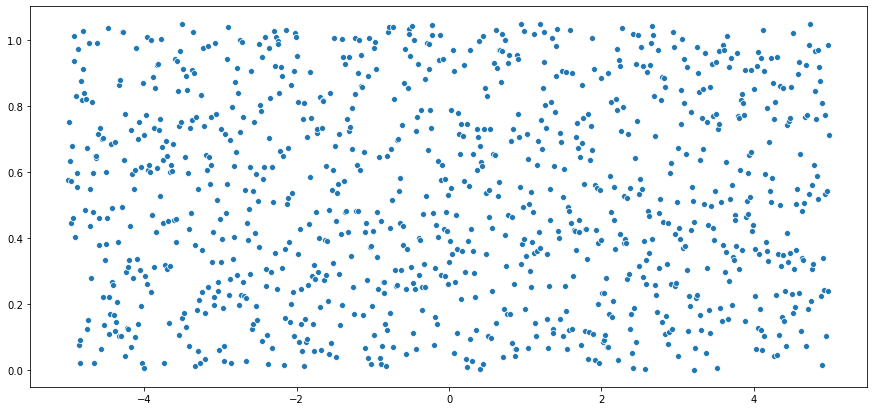

In [8]:
np.random.seed(0)

X = np.arange(-5, 5, 0.01)
y = np.random.rand(len(X))

df = numerical_correlations(X, randomize(y, 20))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

All of the coefficient values are close to 0 indicating no correlation, which is ok since both ranges are random. Looking at the runtime, we can see vast differences. Pearson's is by far the fastest - 6x faster than spearman while distance and mic are in the completely different league.

Note: if you want to experiment faster, make sure you turn off p-value calculations by setting the parameter calc_p_values to False.

## Linear function ##

index,coefficient,p_value,runtime,runtime_multiple
pearson,0.994984,0,0.000206709,1
spearman,0.995084,0,0.00136662,7
kendall,0.935007,0,0.000723124,3
distance,0.993957,nan,0.0693903,336
mic,0.98639,nan,0.0632195,306


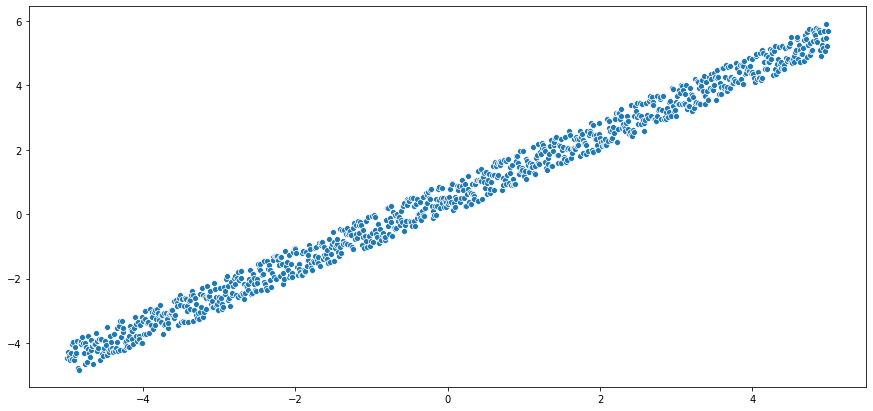

In [9]:
X = np.arange(-5, 5, 0.01)
y = X

df = numerical_correlations(X, randomize(y, 10))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

We can see good correlation from all coefficients, which is also expected since ranges are dependent. Runtime values stay in the same ranges except for distance and mic, where runtime has decreased significantly in respect to the previous test.

## Linear function with outliers ##

index,coefficient,p_value,runtime,runtime_multiple
pearson,0.82554,3.35673e-250,0.000213623,1
spearman,0.903806,0,0.00129485,6
kendall,0.727884,2.57189e-260,0.000724077,3
distance,0.891773,nan,0.0705185,330
mic,0.792028,nan,0.155405,727


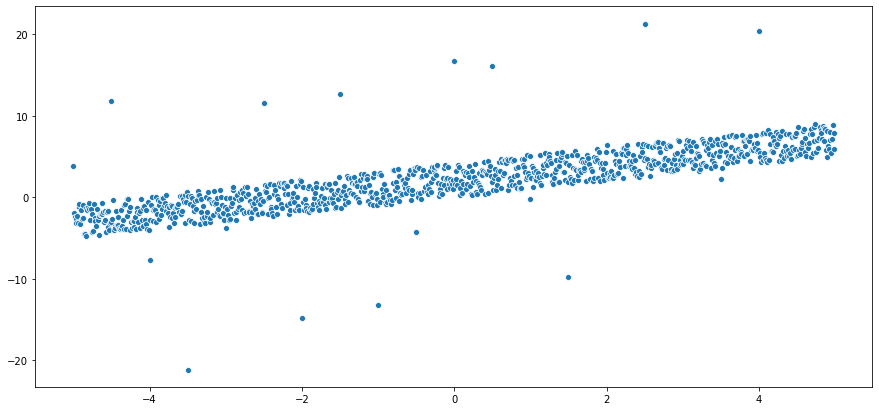

In [10]:
X = np.arange(-5, 5, 0.01)
y = X.copy()

X_outliers = list(np.arange(-5, 5, 0.5))

for index, x in enumerate(X):
    if round(x, 5) in X_outliers:
        y[index] = y[index] + np.random.rand(1) * 20 * (1 if np.random.random() < 0.5 else -1)
            
df = numerical_correlations(X, randomize(y, 10))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

We added some outliers to the mix and clearly we get the best performance from spearman and distance correlation.

## Negative linear function ##

index,coefficient,p_value,runtime,runtime_multiple
pearson,-0.994979,0,0.000204563,1
spearman,-0.995069,0,0.00136971,7
kendall,-0.934987,0,0.000876427,4
distance,0.993934,nan,0.0686851,336
mic,1,nan,0.0617442,302


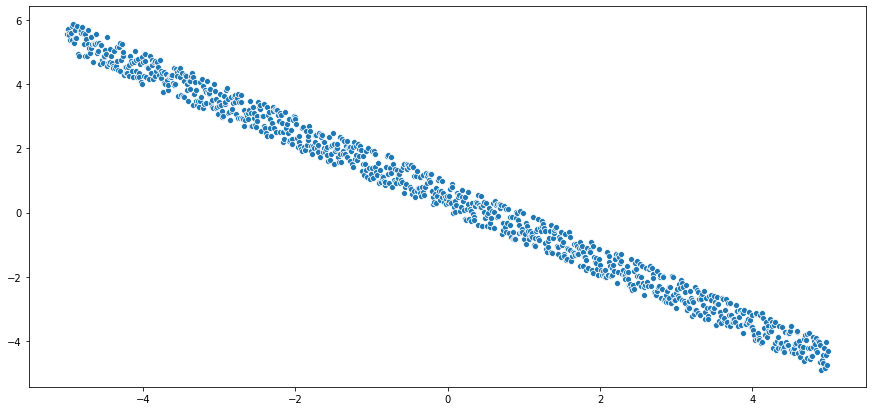

In [11]:
X = np.arange(-5, 5, 0.01)
y = -X

df = numerical_correlations(X, randomize(y, 10))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

I repeated the test with negative function, which indicates the first differences in coefficient values. The first three detected negative correlation, on the other hand distance and mic stayed the same as in previous test.

## Monotonic function ##

Monotonic function is a special non linear function. Its slope always remains either positive or negative. 

index,coefficient,p_value,runtime,runtime_multiple
pearson,0.867339,2.27011e-304,0.000221014,1
spearman,0.97285,0,0.00189447,9
kendall,0.863246,0,0.000836372,4
distance,0.935573,nan,0.0725701,328
mic,0.92431,nan,0.0991395,449


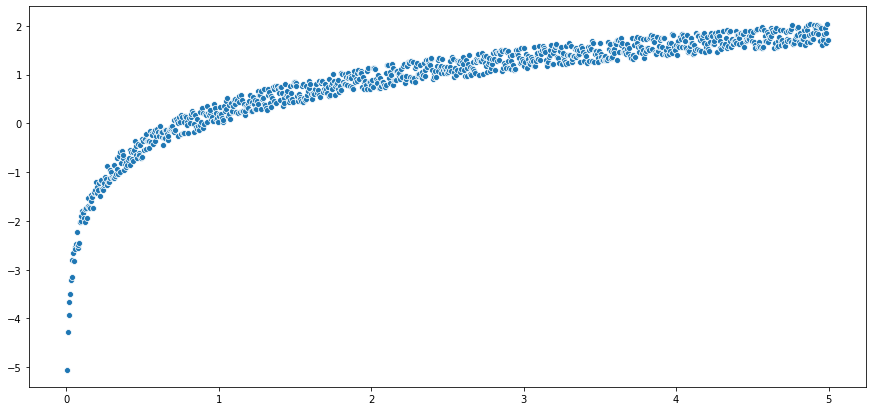

In [12]:
X = np.arange(0.005, 5, 0.005)
y = np.log(X)

df = numerical_correlations(X, randomize(y, 15))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

Although we have pretty good correlation from all coefficients, we can clearly see that spearman's stands out. This is also the first test, where pearson's is not performing very good.

## Non-linear function correlation ##

index,coefficient,p_value,runtime,runtime_multiple
pearson,-0.00359489,0.909604,0.000190496,1
spearman,-0.00246787,0.937873,0.00131059,7
kendall,-0.00114515,0.956757,0.000677586,4
distance,0.487832,nan,0.064393,338
mic,1,nan,0.129251,678


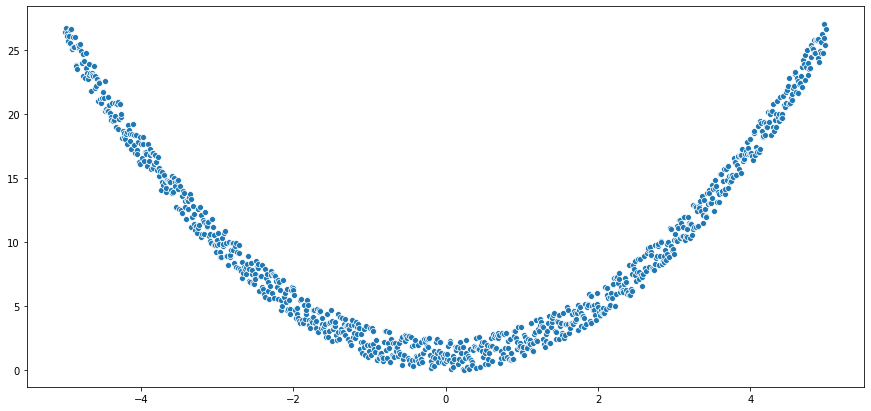

In [13]:
X = np.arange(-5, 5, 0.01)
y = X**2

df = numerical_correlations(X, randomize(y, 10))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

Non-linear function can clearly be detected only by distance and mic coefficient. Especially mic performs really good. Other coefficients show no correlation. Let's try some other non-linear functions.

index,coefficient,p_value,runtime,runtime_multiple
pearson,-0.00101201,0.974502,0.000202894,1
spearman,-0.00165762,0.958247,0.00135851,7
kendall,-0.00160961,0.939246,0.000998259,5
distance,0.379499,nan,0.0661986,326
mic,1,nan,0.126663,624


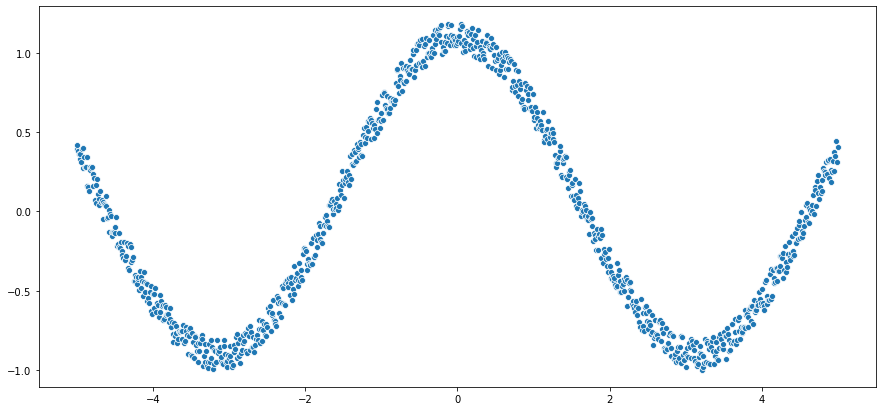

In [14]:
X = np.arange(-5, 5, 0.01)
y = np.cos(X)

df = numerical_correlations(X, randomize(y, 10))

df.apply(lambda s: s.apply(lambda x: format(x, 'g')))

Results are pretty much the same as in the previous test. Looks like mic is the king of non-linear functions.

## Key takeaways ##

- Before calculating the correlation coefficient we need to find out the correlation type - linear, monotonic or non-linear (using scatter plot)
- Pearson's coefficient should only be used for linear correlations, preferably without outliers
- Spearman's coefficient should be used for monotonic correlations and linear correlations with outliers
- Maximal information coefficient (MIC) shines with non-linear correlations, however it is computationaly very expensive

Note: monotonic and non-linear correlations can sometimes be converted to linear but this is the topic for another notebook

<a id="section-7"></a>
# Categorical vs categorical correlation #

Categorical features are extremelly common in most of the datasets. Despite that, finding correlation between two categorical features requires a bit of effort.

In my experiments I will use nominal categorical data. While ordinal data, can be calculated using Spearman's or Kendall's correlation coefficients which I already described at Numerical vs Numerical data correlation.

Basically there are two ways of calculating correlations:
- Statistical hypothesis testing => chi-square test
- Probability theory => mutual information

I will compare the following tests / coefficients:
- Chi-square test for testing the null hypothesis of independence between two variables. Chi-square statistic has to be greater to its critical value to indicate correlation.
- Cramer's V coefficient is a Chi-square test with the normalization layer on top, which puts it into the 0 and 1 range.
- Mutual information measures the amount of information one can obtain from one random variable given another. Basicaly it measures the distance between two probability distribution.
- Normalized mutual information is Mutual Information with the normalization layer on top which puts it into the 0 and 1 range.


| Coefficient                    | Perfect correlation value | No correlation value |
|--------------------------------|---------------------------|----------------------|
| Chi-square                     |     > Critical value      |           0          |
| Cramer's V                     |             1             |           0          |
| Mutual information             |            > 1            |           0          |
| Normalized mutual information  |             1             |           0          |

In [15]:
from scipy.stats import chi2_contingency, chi2
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

def categorical_correlations(X, Y):
    
    chi = []
    cram = []
    mic = []
    muti = []
    nmuti = []
    amuti = []
    
    fig, ax = plt.subplots(1,1,figsize=(15,7))
    sns.countplot(x=X, hue=Y)

    with catchtime() as t_chi:
        chisquared = chi2_contingency(observed=pd.crosstab(X, Y, margins=False))
        
        crit = chi2.ppf(q=0.95, df=chisquared[2] - 1)

        print("Chi2 critical value: " + str(crit))

        p_value = 1 - chi2.cdf(x=chisquared[0], df=chisquared[2] - 1)

    with catchtime() as t_cram:
        cramer = cramers_corrected_stat(X, Y)

#     with catchtime() as t_mic:
#         micc = miccorr(LabelEncoder().fit_transform(X), LabelEncoder().fit_transform(Y), calc_p_values, p_values_iterations)
        
    with catchtime() as t_muti:
        mutual_info = mutual_info_classif(LabelEncoder().fit_transform(X).reshape(-1, 1), LabelEncoder().fit_transform(Y), discrete_features=True)[0], np.nan
    
    with catchtime() as t_nmuti:
        nmutual_info = normalized_mutual_info_score(LabelEncoder().fit_transform(X), LabelEncoder().fit_transform(Y)), np.nan
        
#     with catchtime() as t_amuti:
#         amutual_info = adjusted_mutual_info_score(LabelEncoder().fit_transform(X), LabelEncoder().fit_transform(Y)), 0
        
    chi = [chisquared[0], chisquared[1], t_chi.t]
    cram = [cramer[0], cramer[1], t_cram.t]
#     mic = [micc[0], micc[1], t_mic.t]
    muti = [mutual_info[0], mutual_info[1], t_muti.t]
    nmuti = [nmutual_info[0], nmutual_info[1], t_nmuti.t]
#     amuti = [amutual_info[0], amutual_info[1], t_amuti.t]
    
    df = pd.DataFrame({"index": ["coefficient", "p_value", "runtime"], "Chi2": chi, "Cramer's V":cram, "Mutual Information": muti,"Normalized Mutual Information": nmuti}).set_index("index")
    df = df.T
    df["runtime_multiple"] = round(df["runtime"] / min (df["runtime"]))
    return df

def cramers_corrected_stat(X, Y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    crosstab = pd.crosstab(X, Y, margins=False)
    
    chi2 = chi2_contingency(crosstab)
    
    n = crosstab.sum().sum()
    
    phi2 = chi2[0]/n
    r,k = crosstab.shape
    
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))), chi2[1]

## Random balanced categories correlation ##

Chi2 critical value: 7.814727903251179


index,coefficient,p_value,runtime,runtime_multiple
Chi2,2.396364,0.663284,0.021359,2.0
Cramer's V,0.000000,0.663284,0.015950,1.0
Mutual Information,0.000120,NaN,0.015977,1.0
Normalized Mutual Information,0.000104,NaN,0.012701,1.0


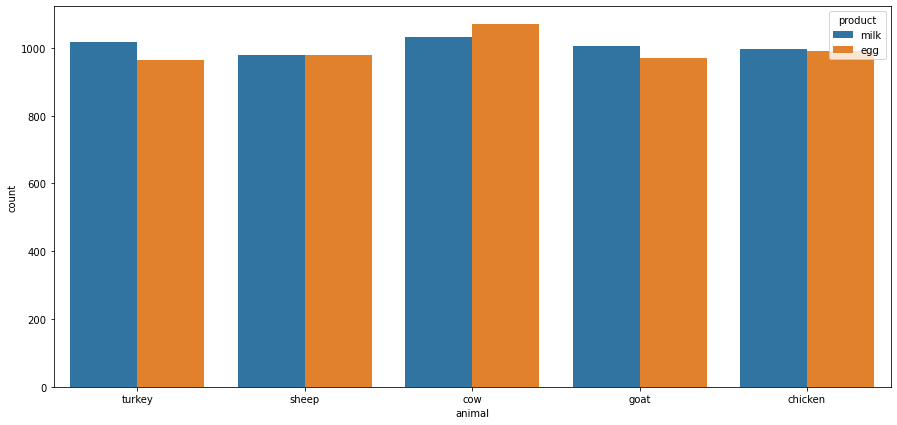

In [16]:
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.5, 0.5], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
categorical_correlations(df["animal"], df["product"])

All coefficients clearly show the absence of correlation between features. Calculation time is a bit faster with mutual information coefficients, but there is no significant difference.

## Random imbalanced categories correlation ##

Chi2 critical value: 7.814727903251179


index,coefficient,p_value,runtime,runtime_multiple
Chi2,2.965898,0.563548,0.016359,1.0
Cramer's V,0.000000,0.563548,0.015319,1.0
Mutual Information,0.000150,NaN,0.011299,1.0
Normalized Mutual Information,0.000161,NaN,0.012003,1.0


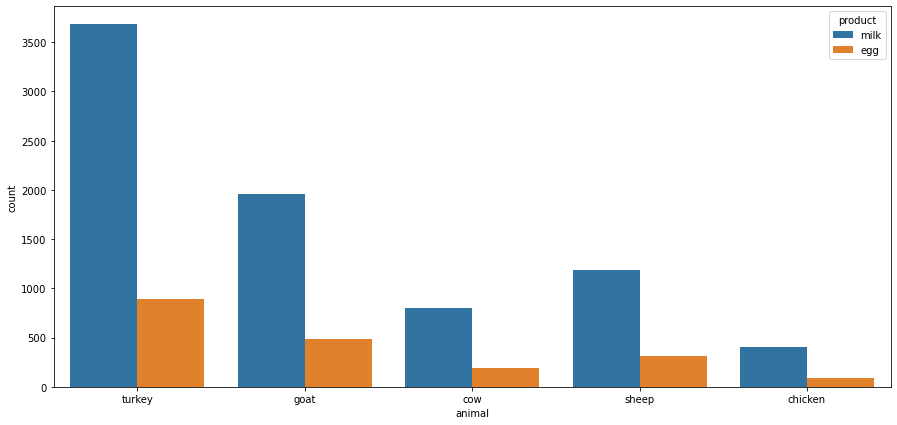

In [17]:
# 2 categorical feature imbalance
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.45, 0.1, 0.25, 0.15, 0.05], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.2, 0.8], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
categorical_correlations(df["animal"], df["product"])

Adding imbalance to the other categorical features doesn't affect the coefficients, which still show the randomness of data.

## Adding feature dependence ##

Chi2 critical value: 7.814727903251179


index,coefficient,p_value,runtime,runtime_multiple
Chi2,1654.431417,0.0,0.017014,1.0
Cramer's V,0.406275,0.0,0.015536,1.0
Mutual Information,0.117586,NaN,0.011510,1.0
Normalized Mutual Information,0.103028,NaN,0.012199,1.0


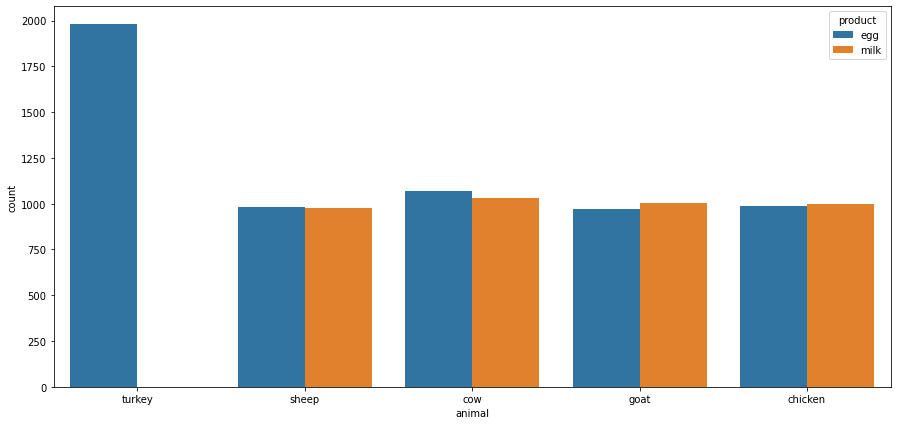

In [18]:
# Balanced data
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.5, 0.5], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
df.loc[(df["animal"] == "turkey"), "product"] = "egg"
categorical_correlations(df["animal"], df["product"])

Chart shows a clear correlation between "turkey" and "egg" categories. Chi2 only indicated that there is a correlation (null hypothesiss is rejected) but there is no strenght of correlation. Strenght can be found looking at the Cramer's V, which shows a moderate correlation between two features. On the other hand, mutual information cofficiens detected low correlation between features.

Lets try the same on the imbalanced dataset.

Chi2 critical value: 7.814727903251179


index,coefficient,p_value,runtime,runtime_multiple
Chi2,6481.424354,0.0,0.017937,1.0
Cramer's V,0.804865,0.0,0.016854,1.0
Mutual Information,0.413917,NaN,0.012021,1.0
Normalized Mutual Information,0.404152,NaN,0.012943,1.0


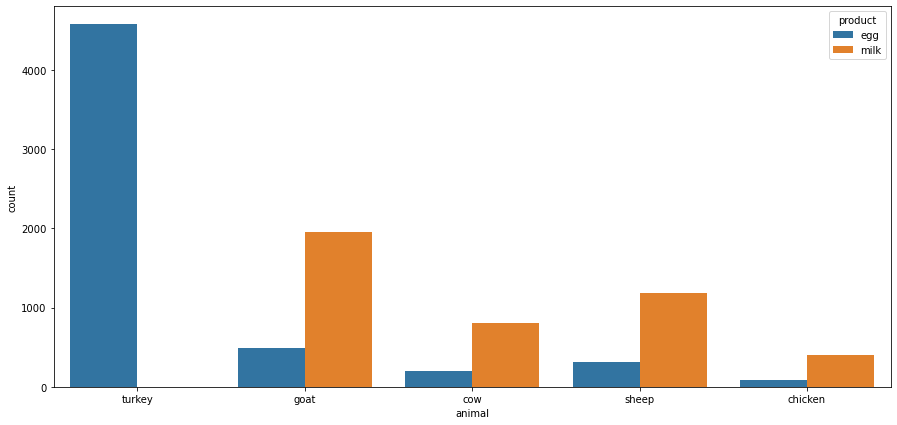

In [19]:
# Imbalanced data
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.45, 0.1, 0.25, 0.15, 0.05], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.2, 0.8], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
df.loc[(df["animal"] == "turkey"), "product"] = "egg"
categorical_correlations(df["animal"], df["product"])

Enforcing the correlation in bigger categories impacted the coefficients in a positive way, boosting the correlation amount. Cramer's V is indicating high correlation while mutual information coefficients show moderate correlation. I believe Cramer's V is a bit too optimistic.

Let's try enforcing correlation on a "chicken" category, which is much smaller.

Chi2 critical value: 7.814727903251179


index,coefficient,p_value,runtime,runtime_multiple
Chi2,1643.943383,0.0,0.016145,1.0
Cramer's V,0.404982,0.0,0.014788,1.0
Mutual Information,0.074154,NaN,0.011432,1.0
Normalized Mutual Information,0.077586,NaN,0.011831,1.0


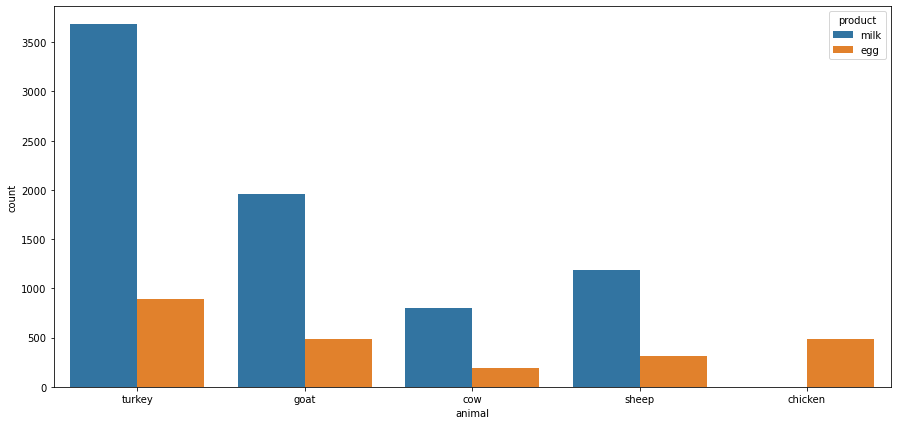

In [20]:
# Imbalanced data
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.45, 0.1, 0.25, 0.15, 0.05], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.2, 0.8], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
df.loc[(df["animal"] == "chicken"), "product"] = "egg"
categorical_correlations(df["animal"], df["product"])

All coefficient values decreased. Cramer's V dropped to the level of balanced data score.

## Creating perfect correlation ##

Chi2 critical value: 7.814727903251179


index,coefficient,p_value,runtime,runtime_multiple
Chi2,10000.000000,0.0,0.017858,2.0
Cramer's V,0.999850,0.0,0.016515,1.0
Mutual Information,0.671567,NaN,0.011127,1.0
Normalized Mutual Information,0.588918,NaN,0.011792,1.0


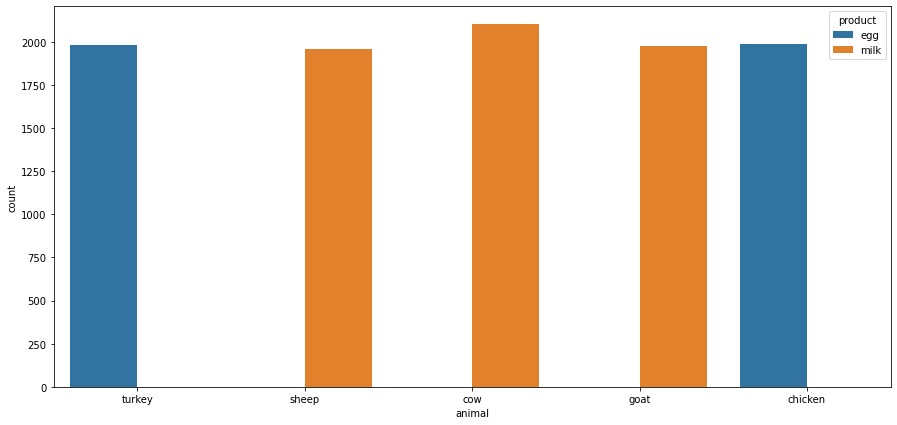

In [21]:
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.5, 0.5], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
df.loc[(df["animal"] == "turkey"), "product"] = "egg"
df.loc[(df["animal"] == "goat"), "product"] = "milk"
df.loc[(df["animal"] == "sheep"), "product"] = "milk"
df.loc[(df["animal"] == "cow"), "product"] = "milk"
df.loc[(df["animal"] == "chicken"), "product"] = "egg"
categorical_correlations(df["animal"], df["product"])

We now have a perfect one-way correlation. Knowing the animal, we also know the product, however it doesn't work the other way around.
Cramer's V detected the perfect correlation, which is also a bit too optimistic since there is no two-way correlation.
I believe mutual information coefficients are closer to the actual truth.

Now lets try to make a perfect two-way correlation.

Chi2 critical value: 24.995790139728616


index,coefficient,p_value,runtime,runtime_multiple
Chi2,40000.000000,0.0,0.016072,2.0
Cramer's V,1.000000,0.0,0.016293,2.0
Mutual Information,1.609113,NaN,0.010514,1.0
Normalized Mutual Information,1.000000,NaN,0.011290,1.0


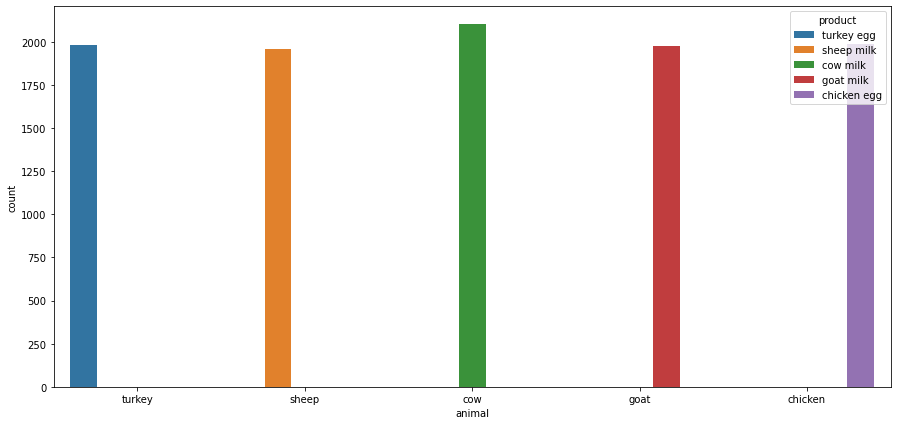

In [22]:
np.random.seed(12)

animal = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=10000)
product = np.random.choice(a=["egg", "milk"], p=[0.5, 0.5], size=10000)
df = pd.DataFrame({"animal": animal, "product": product})
df.loc[(df["animal"] == "turkey"), "product"] = "turkey egg"
df.loc[(df["animal"] == "goat"), "product"] = "goat milk"
df.loc[(df["animal"] == "sheep"), "product"] = "sheep milk"
df.loc[(df["animal"] == "cow"), "product"] = "cow milk"
df.loc[(df["animal"] == "chicken"), "product"] = "chicken egg"
categorical_correlations(df["animal"], df["product"])

Like expected, all of the coefficients now show the perfect correlation.

## Key takeaways ##

- Ordinal categorical data correlation can be calculated using Spearman's or Kendall's rank correlation
- Nominal categorical data correlation can be calculated using Chi-squared / Cramer's V or (Normalized) mutual information coefficient.
- Chi-squared coefficient is harder to read since you need to compare the result to the critial value
- Cramer's V coefficient seems a bit too optimistic, especially with imbalanced categorical variables
- Cramer's V is considering one-way correlation only
- Normalized mutual information coefficient considers two-way correlation, which seem closer to the actual truth

<a id="section-8"></a>
# Numerical vs categorical correlation #

The last remaining combination of features that should be covered is numerical vs categorical correlation.

Correlation coeficients:
- Point biserial correlation coefficient compares binary and continuos features in a similar way to the pearson's coefficient between numerical features
- One-way ANOVA is a technique which is comparing the means of different groups. Numerical data has to be distributed normally
- Normalized mutual information is Mutual Information with the normalization layer on top which puts it into the 0 and 1 range
- Adjusted mutual information is a variation of Mutual Information for comparing clusters of data

| Coefficient                    | Perfect correlation value | Perfect negative correlation value | No correlation value |
|--------------------------------|---------------------------|------------------------------------|----------------------|
| Point biserial correlation     |             1             |                 -1                 |           0          |
| ANOVA                          |     > Critical value      |          > Critical value          |   < Critical value   |
| Normalized mutual information  |             1             |                  1                 |           0          |
| Adjusted mutual information    |             1             |                  1                 |           0          |

In my experiments, I will ignore Point-biserial correlation, since I won't use binary categorical feature.

In [23]:
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency, chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler

def categorical_numerical_correlations(X, Y, group_list):
    
    pbs = []
    ano = []
    muti = []
    nmuti = []
    amuti = []
    krus = []
    
    bins = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    
    
    fig, ax = plt.subplots(1,1,figsize=(15,7))
    sns.stripplot(x=X, y=Y)
    sns.pointplot(x=X, y=Y)
    

    with catchtime() as t_pbs:
        point_biserial = stats.pointbiserialr(LabelEncoder().fit_transform(X), Y)

    with catchtime() as t_ano:
        
        anova = stats.f_oneway(*group_list)
        
        a = len(X.value_counts())
        N = len(X)
        dfn = a - 1
        dfd = N - a

        crit = stats.f.ppf(0.95, dfn, dfd)
        print("F critical value: " + str(crit))


    with catchtime() as t_muti:
        mutual_info = mutual_info_classif(LabelEncoder().fit_transform(X).reshape(-1, 1), np.searchsorted(bins, Y))[0], np.nan
    
    with catchtime() as t_nmuti:
        nmutual_info = normalized_mutual_info_score(LabelEncoder().fit_transform(X), np.searchsorted(bins, Y)), np.nan
        
    with catchtime() as t_amuti:
        amutual_info = adjusted_mutual_info_score(LabelEncoder().fit_transform(X), np.searchsorted(bins, Y)), np.nan
        
    pbs = [point_biserial[0], point_biserial[1], t_pbs.t]
    ano = [anova[0], anova[1], t_ano.t]
    muti = [mutual_info[0], mutual_info[1], t_muti.t]
    nmuti = [nmutual_info[0], nmutual_info[1], t_nmuti.t]
    amuti = [amutual_info[0], amutual_info[1], t_amuti.t]
    
    df = pd.DataFrame({"index": ["coefficient", "p_value", "runtime"], "ANOVA":ano, "Normalized mutual information": nmuti, "Adjusted mutual information": amuti}).set_index("index")
    df = df.T
    df["runtime_multiple"] = round(df["runtime"] / min (df["runtime"]))
    return df

## Random balanced categories correlation ##

F critical value: 2.3808758069291818


index,coefficient,p_value,runtime,runtime_multiple
ANOVA,1.177958,0.318878,0.002673,1.0
Normalized mutual information,0.003116,NaN,0.003022,1.0
Adjusted mutual information,-0.000933,NaN,0.004187,2.0


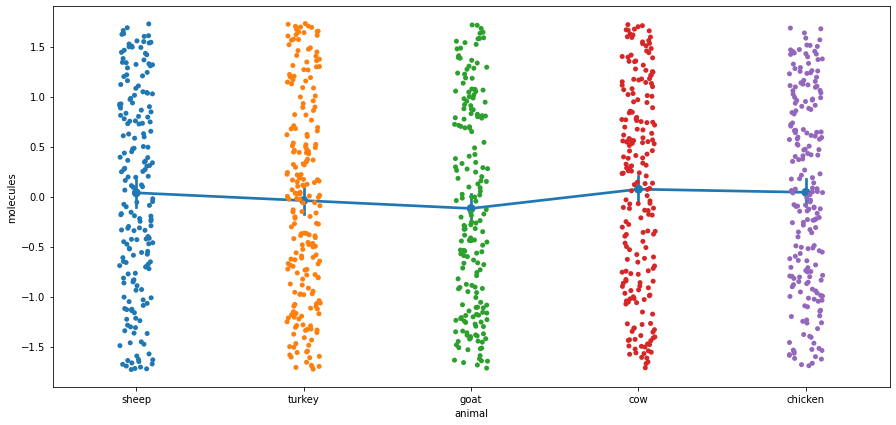

In [24]:
np.random.seed(10)

Y = np.arange(-5, 5, 0.01)
X = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=len(Y))

df = pd.DataFrame({"animal": X, "molecules": Y})

df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()
categorical_numerical_correlations(df["animal"], df["molecules"], df.groupby("animal")["molecules"].apply(list))

All coefficients clearly show the randomness of data that is actually random.

## Random imbalanced categories correlation ##

F critical value: 2.3808758069291818


index,coefficient,p_value,runtime,runtime_multiple
ANOVA,2.769726,0.026243,0.003131,1.0
Normalized mutual information,0.006919,NaN,0.003322,1.0
Adjusted mutual information,0.002448,NaN,0.004060,1.0


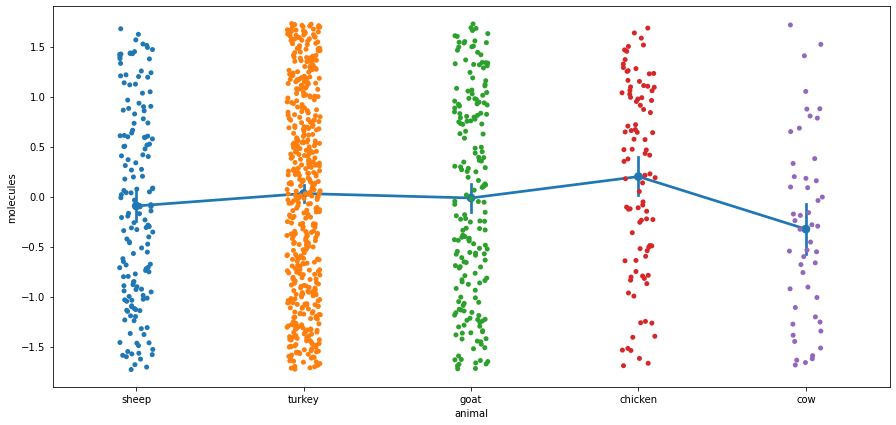

In [25]:
np.random.seed(10)

Y = np.arange(-5, 5, 0.01)
X = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.5, 0.05, 0.2, 0.15, 0.1], size=len(Y))

df = pd.DataFrame({"animal": X, "molecules": Y})

df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()
categorical_numerical_correlations(df["animal"], df["molecules"], df.groupby("animal")["molecules"].apply(list))

ANOVA coefficient got slightly above the critical value. However this depends on the random seed of the values. Feel free to change it and expore the differences.
On the other hand, Mutual information coefficients still show the randomness of data.

## Adding feature dependence ##

F critical value: 2.3808758069291818


index,coefficient,p_value,runtime,runtime_multiple
ANOVA,15.000934,6.530105e-12,0.002102,1.0
Normalized mutual information,0.115357,NaN,0.002864,1.0
Adjusted mutual information,0.111700,NaN,0.003856,2.0


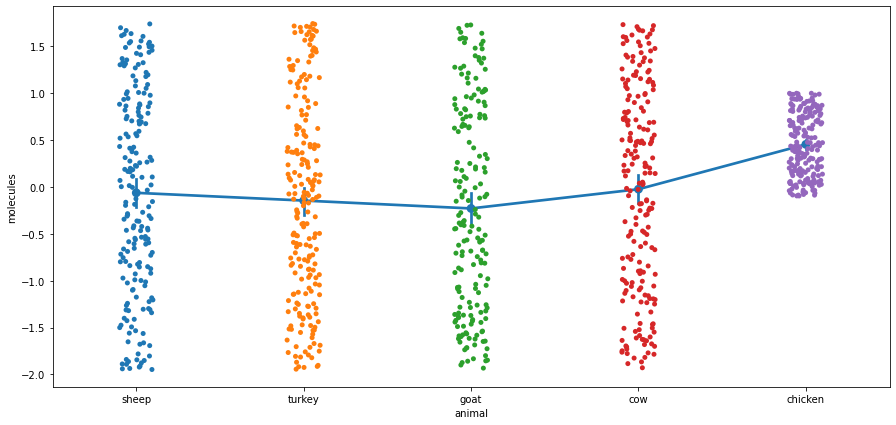

In [26]:
# Balanced data

np.random.seed(10)

Y = np.arange(-5, 5, 0.01)

X = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=len(Y))
df = pd.DataFrame({"animal": X, "molecules": Y})
df.loc[(df["animal"] == "chicken"), "molecules"] = (np.random.rand(len(df[df["animal"] == "chicken"]), 1)) * 3

df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()
categorical_numerical_correlations(df["animal"], df["molecules"], df.groupby("animal")["molecules"].apply(list))

As soon as there is some feature dependence, ANOVA clearly indicates it, however it only tells us that there is a difference in means between groups of data. On the other hand Mutual information coefficients clearly look at a bigger picture and only indicate relatively small correlation betwe

F critical value: 2.3808758069291818


index,coefficient,p_value,runtime,runtime_multiple
ANOVA,271.669570,8.362976e-158,0.002342,1.0
Normalized mutual information,0.225696,NaN,0.002830,1.0
Adjusted mutual information,0.221555,NaN,0.003873,2.0


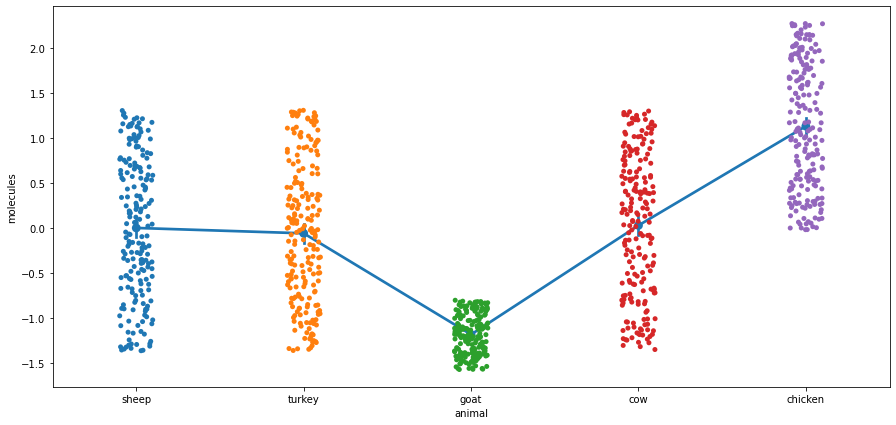

In [27]:
# Balanced data
np.random.seed(10)

Y = np.arange(-5, 5, 0.01)
X = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=len(Y))

df = pd.DataFrame({"animal": X, "molecules": Y})
df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()

df.loc[(df["animal"] == "chicken"), "molecules"] = (np.random.rand(len(df[df["animal"] == "chicken"]), 1)) * 3
df.loc[(df["animal"] == "goat"), "molecules"] = (np.random.rand(len(df[df["animal"] == "goat"]), 1)) - 2

df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()
categorical_numerical_correlations(df["animal"], df["molecules"], df.groupby("animal")["molecules"].apply(list))

Adding more feature dependence increases the ANOVA as well as mutual information coefficients.

F critical value: 2.3808758069291818


index,coefficient,p_value,runtime,runtime_multiple
ANOVA,188.647079,2.454562e-120,0.002284,1.0
Normalized mutual information,0.267435,NaN,0.002843,1.0
Adjusted mutual information,0.261792,NaN,0.003813,2.0


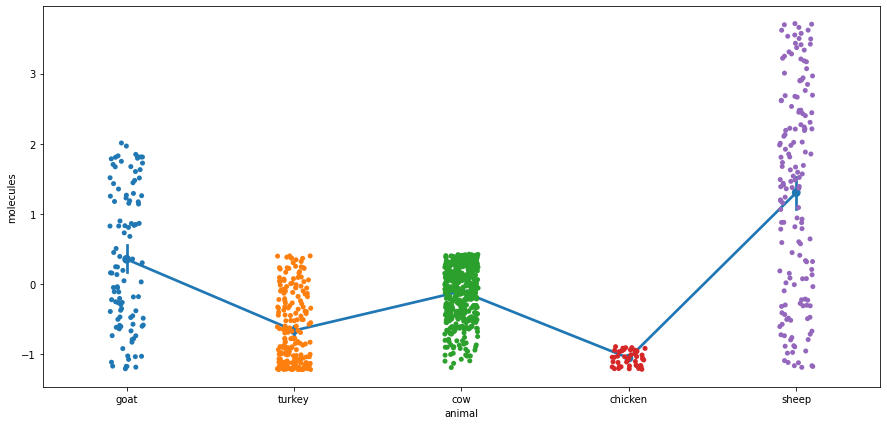

In [28]:
# Imbalanced data
np.random.seed(10)

Y = np.arange(-5, 5, 0.01)
X = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.5, 0.1, 0.15, 0.05], size=len(Y))
df = pd.DataFrame({"animal": X, "molecules": Y})

df.loc[(df["animal"] == "turkey"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "turkey"]), 1)) ** 2)
df.loc[(df["animal"] == "cow"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "cow"]), 1)) ** (1/2))
df.loc[(df["animal"] == "goat"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "goat"]), 1)) * 2)
df.loc[(df["animal"] == "sheep"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "sheep"]), 1)) * 3)
df.loc[(df["animal"] == "chicken"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "chicken"]), 1)) * 0.2)

df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()
categorical_numerical_correlations(df["animal"], df["molecules"], df.groupby("animal")["molecules"].apply(list))

ANOVA indicates that it is basically impossible that this dataset could be generated randomly. Mutual information coefficiens also show correlation, however Adjusted MI is always a bit more pessimistic.

## Creating perfect correlation ##

F critical value: 2.3808758069291818


index,coefficient,p_value,runtime,runtime_multiple
ANOVA,-2.185840e+18,NaN,0.002170,1.0
Normalized mutual information,9.067355e-01,NaN,0.002822,1.0
Adjusted mutual information,9.063514e-01,NaN,0.003937,2.0


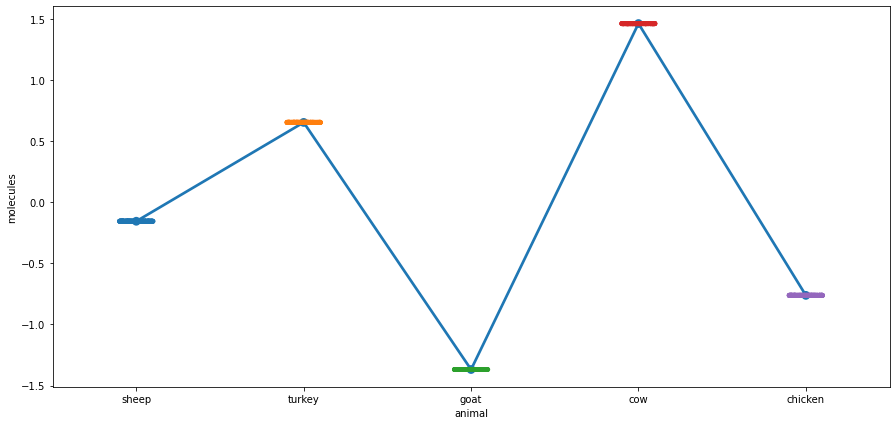

In [29]:
# Balanced data
np.random.seed(10)

Y = np.arange(-5, 5, 0.01)
X = np.random.choice(a=["turkey", "cow", "goat", "sheep", "chicken"], p=[0.2, 0.2, 0.2, 0.2, 0.2], size=len(Y))
df = pd.DataFrame({"animal": X, "molecules": Y})

df.loc[(df["animal"] == "turkey"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "turkey"]), 1)) * 0) + 2
df.loc[(df["animal"] == "cow"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "cow"]), 1)) * 0) + 4
df.loc[(df["animal"] == "goat"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "goat"]), 1)) * 0) - 3
df.loc[(df["animal"] == "sheep"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "sheep"]), 1)) * 0) + 0
df.loc[(df["animal"] == "chicken"), "molecules"] = ((np.random.rand(len(df[df["animal"] == "chicken"]), 1)) * 0) - 1.5

df["molecules"] = (df["molecules"] - df["molecules"].mean()) / df["molecules"].std()
categorical_numerical_correlations(df["animal"], df["molecules"], df.groupby("animal")["molecules"].apply(list))

Mutual information coefficients indicate almost perfect correlation, however I can't seem to achieve the perfect score with standardization of data. There is also an odd negative ANOVA coefficient?

## Key takeaways ##

- Point biserial correlation is the way to go when working with binary categorical feature
- ANOVA coefficient is harder to read since you need to compare the result to the critial value
- ANOVA coefficient is extremelly sensitive to even the smallest deviations in data
- ANOVA coefficient is not working good with small imbalanced datasets
- Adjusted Mutual Information is more pessimistic than Normalized Mutual Information, it is also a bit slower
- Both Mutual Information scores are much better for reading the correlation between two features

Sources:

https://en.wikipedia.org/wiki/Correlation_and_dependence

https://en.wikipedia.org/wiki/Correlation_coefficient

https://www.investopedia.com/terms/p/p-value.asp

https://www.dictionary.com/browse/causation

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

https://nitin9809.medium.com/data-types-for-ml-beginners-b94fc9d88ed

https://letstalkaboutscience.wordpress.com/2013/07/30/scientific-inquiry-and-critical-thinking/

https://gist.github.com/wladston/c931b1495184fbb99bec

https://www.investopedia.com/terms/m/multicollinearity.asp

https://en.wikipedia.org/wiki/One-way_analysis_of_variance

https://www.statology.org/point-biserial-correlation-python/

http://mlwiki.org/index.php/One-Way_ANOVA_F-Test

https://passel2.unl.edu/view/lesson/9beaa382bf7e/8

https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

https://www.spss-tutorials.com/cramers-v-what-and-why/

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/anova/how-to/one-way-anova/interpret-the-results/key-results/

https://www.dummies.com/education/math/business-statistics/how-to-find-the-critical-values-for-an-anova-hypothesis-using-the-f-table/

http://www.socr.ucla.edu/Applets.dir/F_Table.html